## Imports

In [78]:
import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns
import dask.dataframe as df
from dask_ml.impute import SimpleImputer
from dask_ml.xgboost import XGBClassifier
from dask_ml.preprocessing import LabelEncoder
from dask.distributed import Client
from dask import compute
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

In [18]:
SEED = 0
JOBS = 10

In [19]:
client = Client(n_workers=JOBS)

/home/vladimir/anaconda3/envs/ml/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42709 instead
  http_address["port"], self.http_server.port


## Data Exploration

In [3]:
data = df.read_csv('./data/train_transaction.csv', header=0)

In [4]:
data

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
npartitions=11,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float6

In [5]:
data.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 394 entries, TransactionID to V339
dtypes: object(14), float64(376), int64(4)

In [5]:
data['isFraud'].value_counts().compute()

0    569877
1     20663
Name: isFraud, dtype: int64

From the table we can see that we are dealing with an imbalanced dataset.

### Missing Values

In [11]:
data.loc[:, 'TransactionAmt': 'M9'].isnull().sum().compute()

TransactionAmt         0
ProductCD              0
card1                  0
card2               8933
card3               1565
card4               1577
card5               4259
card6               1571
addr1              65706
addr2              65706
dist1             352271
dist2             552913
P_emaildomain      94456
R_emaildomain     453249
C1                     0
C2                     0
C3                     0
C4                     0
C5                     0
C6                     0
C7                     0
C8                     0
C9                     0
C10                    0
C11                    0
C12                    0
C13                    0
C14                    0
D1                  1269
D2                280797
D3                262878
D4                168922
D5                309841
D6                517353
D7                551623
D8                515614
D9                515614
D10                76022
D11               279287
D12               525823


In [24]:
X = data[['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']]
y = data['isFraud']
X

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
npartitions=11,,,,,,,,
,float64,object,int64,float64,float64,object,float64,object
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


In [25]:
mean_imp = SimpleImputer(strategy='mean')
mode_imp = SimpleImputer(strategy='most_frequent')

In [26]:
X[['card1', 'card2', 'card3', 'card5']] = mean_imp.fit_transform(X[['card1', 'card2', 'card3', 'card5']])
X[['card4', 'card6']] = mode_imp.fit_transform(X[['card4', 'card6']])

In [27]:
X.isnull().sum().compute()

TransactionAmt    0
ProductCD         0
card1             0
card2             0
card3             0
card4             0
card5             0
card6             0
dtype: int64

In [39]:
def name(i):
    return f'{i}'

In [40]:
X.to_csv('./data/base_features/*.csv', header=True, index=False, name_function=name)
y.to_csv('./data/target/*.csv', header=True, index=False, name_function=name)

In order to preserve order between partitions paths created with ``name_function`` should sort to partition order
In order to preserve order between partitions paths created with ``name_function`` should sort to partition order


['/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/0.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/1.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/2.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/3.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/4.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/5.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/6.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/7.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/8.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/9.csv',
 '/home/vladimir/PycharmProjects/IEEE-CISFraudDetection/data/target/10.csv']

In [97]:
X = df.read_csv('./data/base_features/*.csv', header=0)
y = df.read_csv('./data/target/*.csv', header=0)

In [99]:
y_pos = y[y['isFraud']==1]
A = X.loc[y_pos.index, :]
y_neg = y[y['isFraud']==0]
B = X.loc[y_neg.index, :].sample(frac=0.1, random_state=SEED)
A, B, y_pos, y_neg = compute(A, B, y_pos, y_neg)

<AxesSubplot:xlabel='card6', ylabel='count'>

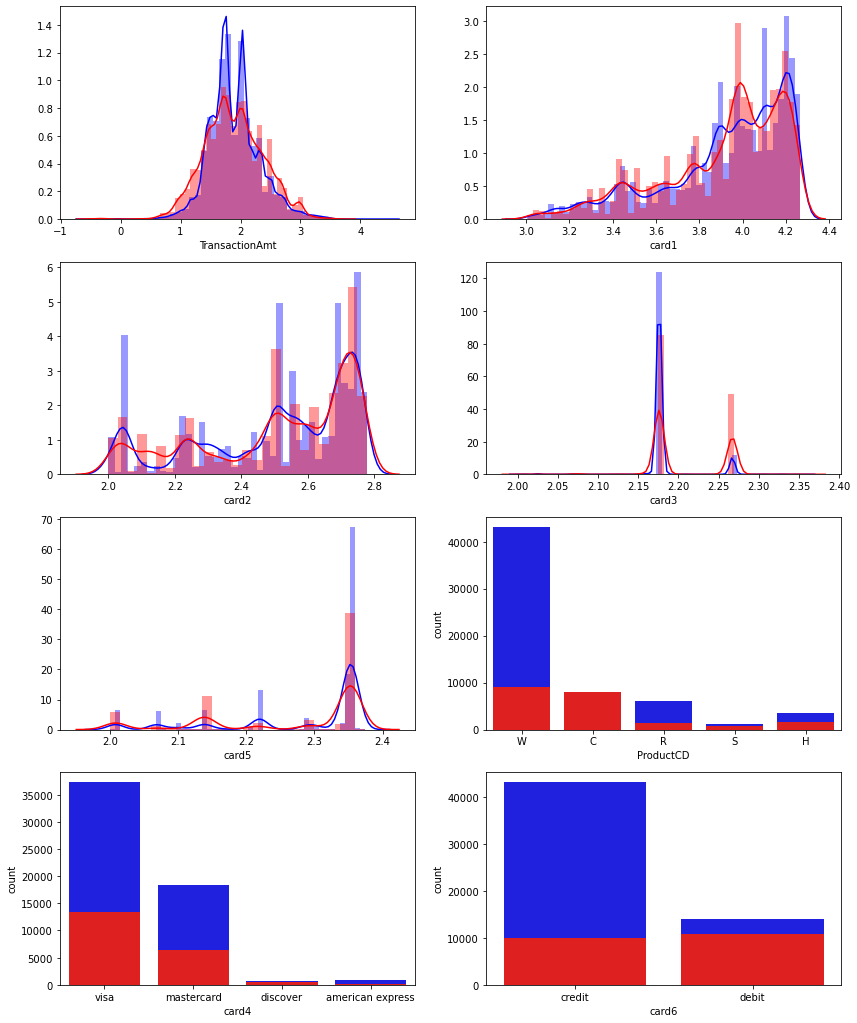

In [100]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=(14,18))
sns.distplot(a=numpy.log10(B['TransactionAmt']), ax=ax[0,0], color='blue')
sns.distplot(a=numpy.log10(A['TransactionAmt']), ax=ax[0,0], color='red')
sns.distplot(a=numpy.log10(B['card1']), ax=ax[0,1], color='blue')
sns.distplot(a=numpy.log10(A['card1']), ax=ax[0,1], color='red')
sns.distplot(a=numpy.log10(B['card2']), ax=ax[1,0], color='blue')
sns.distplot(a=numpy.log10(A['card2']), ax=ax[1,0], color='red')
sns.distplot(a=numpy.log10(B['card3']), ax=ax[1,1], color='blue')
sns.distplot(a=numpy.log10(A['card3']), ax=ax[1,1], color='red')
sns.distplot(a=numpy.log10(B['card5']), ax=ax[2,0], color='blue')
sns.distplot(a=numpy.log10(A['card5']), ax=ax[2,0], color='red')
sns.countplot(x='ProductCD', data=B, ax=ax[2,1], color='blue')
sns.countplot(x='ProductCD', data=A, ax=ax[2,1], color='red')
sns.countplot(x='card4', data=B, ax=ax[3,0], color='blue')
sns.countplot(x='card4', data=A, ax=ax[3,0], color='red')
sns.countplot(x='card6', data=B, ax=ax[3,1], color='blue')
sns.countplot(x='card6', data=A, ax=ax[3,1], color='red')

In [101]:
C = pandas.concat([A, B])

In [102]:
C[['ProductCD', 'card4', 'card6']] = C[['ProductCD', 'card4', 'card6']].apply(LabelEncoder().fit_transform)

In [103]:
C.head()

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6
203,445.000,4,18268,583.0,150.0,3,226.0,1
240,37.098,0,13413,103.0,185.0,3,137.0,1
243,37.098,0,13413,103.0,185.0,3,137.0,1
245,37.098,0,13413,103.0,185.0,3,137.0,1
288,155.521,0,16578,545.0,185.0,3,226.0,1


In [104]:
C = MinMaxScaler().fit_transform(C)

In [ ]:
C_ = TSNE(n_components=2, n_jobs=JOBS).fit_transform(C)

<AxesSubplot:>

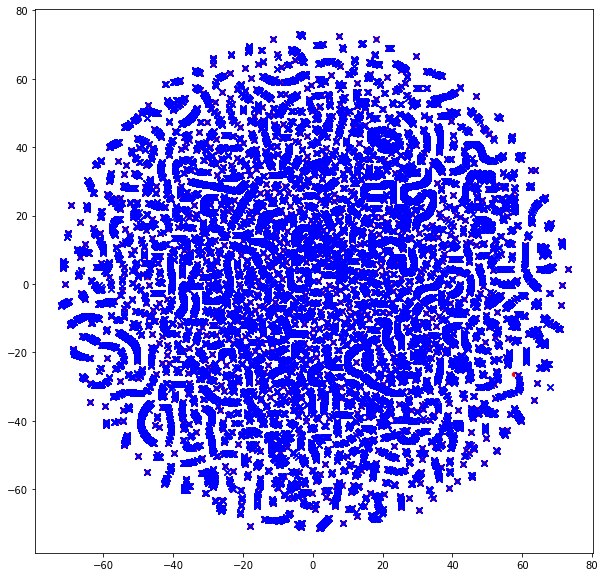

In [96]:
positive = C_[y_pos.index.values, :]
negative = C_[y_neg.index.values, :]
plt.figure(figsize=(10,10))
sns.scatterplot(x=positive[:, 0], y=positive[:, 1], color='red', marker='o', label='Fraud')
sns.scatterplot(x=negative[:, 0], y=negative[:, 1], color='blue', marker='x', label='Clean')
plt.legend()

### One-Hot Encoding

In [4]:
X[['card4', 'card6', 'ProductCD']] = X[['card4', 'card6', 'ProductCD']].astype('category')

In [5]:
X = X.categorize(columns=['card4', 'card6', 'ProductCD'])

In [6]:
X = df.get_dummies(X, columns=['card4', 'card6', 'ProductCD'])

In [7]:
X

,TransactionAmt,card1,card2,card3,card5,card4_american express,card4_discover,card4_mastercard,card4_visa,card6_charge card,card6_credit,card6_debit,card6_debit or credit,ProductCD_C,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W
npartitions=11,,,,,,,,,,,,,,,,,,
,float64,int64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
